# Sentiment analysis of tweets relating to climate change

## Notes about the dataset

- Gives strings of tweets (messages) and sentiment values (sentiment).
- Sentiment is given as values of either -1, 0, 1, 2 where:
    - -1 is negative
    - 0 is neutral, 
    - 1 is positive
    - 2 is news/factual

## Goals

- To train a network to predict whether a tweet is positive or negative. 
- Demonstrate how changing/simplifying the dataset can have a drastic effect on the performance of the NN. 
    - 'A good dataset beats a fancy algorithm'

## Processing steps

Preprocessing steps include:
- set to lower case
- remove stop words
- remove punctuation 
- remove htmls
- remove urls
- remove numbers
- tokenize the words
    - replace words with an integer describing how frequently the words appear. 'Climate' and 'change' were the most common once stop words etc are removed.

I did not do the following due to processing time:

- Lemmatisation (groups words together by replacing them with their lemma/root)
    - e.g. running will be changed to run. 
- Spell checking
    - Was taking too long for this project. 

## Functions

Functions to preprocess the tweets, plot information and split into test and train sets are in separate files in this directory:

- preprocessing_functions.py
- plotting_functions.py
- make_to_train_test.py

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# import ML stuff
import tensorflow as tf
from tensorflow import keras

# import my functions 

from plotting_functions import * 
from preprocessing_functions import * 
from make_to_train_test import * 

# number of words in the dictionary
NB_WORDS = 10000
# maximum tweet length 
max_len = 15


Bad key "text.kerning_factor" on line 4 in
/Users/jamieward/.matplotlib/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "mathtext.fallback" on line 156 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "axes.titley" on line 177 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df = pd.read_csv('./twitter_sentiment_data.csv')
df.head(10)

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
5,0,Unamshow awache kujinga na iko global warming ...,793125429418815489
6,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125430236684289
7,2,RT @CCIRiviera: Presidential Candidate #Donald...,793126558688878592
8,0,RT @AmericanIndian8: Leonardo DiCaprio's clima...,793127097854197761
9,1,#BeforeTheFlood Watch #BeforeTheFlood right he...,793127346106753028


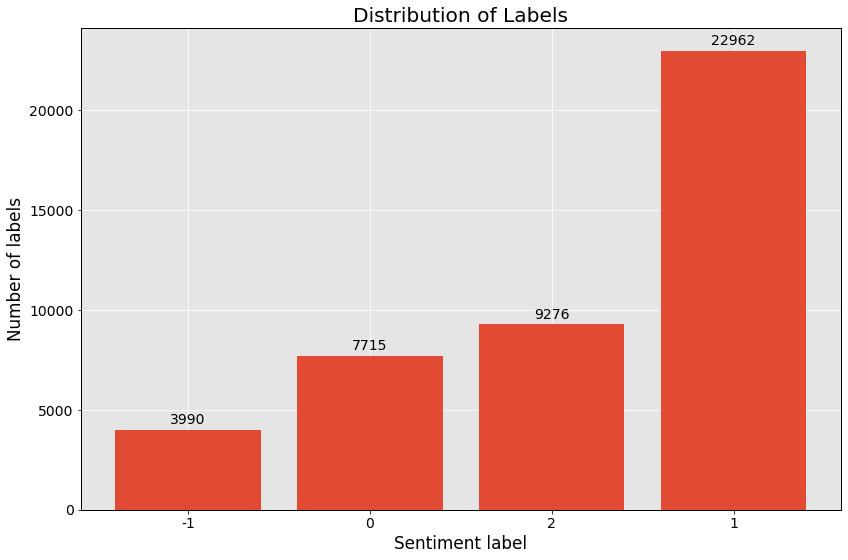

In [3]:
# plot distribution of sentiments 

plot_sentiment_distribution(df)

In [4]:
tweets = df['message'].to_numpy().astype(str)
sentiment = df['sentiment'].to_numpy()

tweets = preprocessing(tweets)

tokenizer = keras.preprocessing.text.Tokenizer(char_level=False, num_words=NB_WORDS, lower=True)
tokenizer.fit_on_texts(tweets)


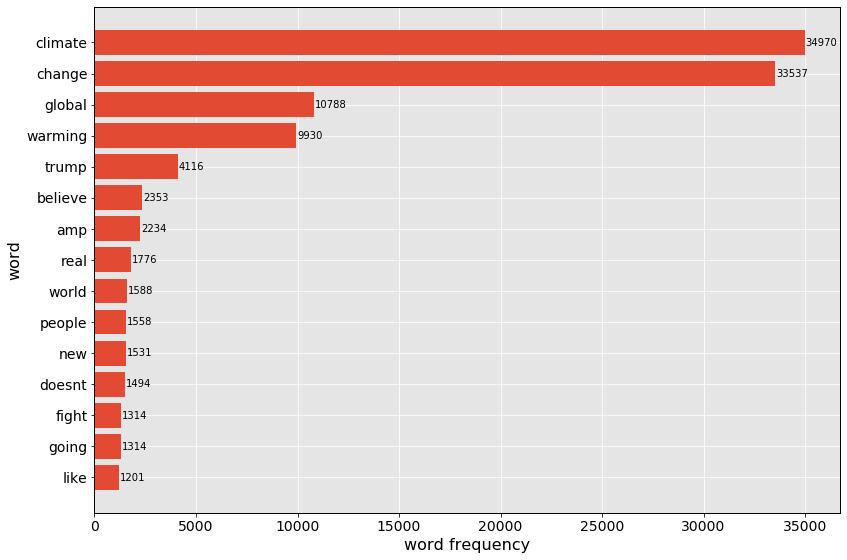

In [5]:
def word_count_frequency(tokenizer, N):
    
    top_N_words = list(tokenizer.word_index.keys())[:N]
    top_N_word_frequency = [tokenizer.word_counts[word] for word in top_N_words]
    
    return top_N_words, top_N_word_frequency

top_N_words, top_N_word_frequency = word_count_frequency(tokenizer, 15)

# plot bar chart
plot_word_frequency(top_N_words, top_N_word_frequency)

In [6]:
# going to make my own embedding first!

def model_1(NB_WORDS, n_out, train_x, train_y, embed_size=128):
    
    batch_size=32
    spe = (0.6 * train_x.shape[0])/batch_size # steps per epoch
    
    model = keras.models.Sequential([
        # embedding layer
        keras.layers.Embedding(NB_WORDS, embed_size, mask_zero=True),
        keras.layers.SpatialDropout1D(0.4),
        keras.layers.LSTM(128,  dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
        keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3),
        keras.layers.Dense(n_out, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', 
              optimizer="adam", metrics=["accuracy"]) 
    history = model.fit(train_x, train_y, epochs=5, validation_split=0.2, batch_size=batch_size, steps_per_epoch=spe)
    
    return history, model


def model_2(NB_WORDS, n_out, train_x, train_y, max_len, embed_size=128):
    
    batch_size=32
    spe = (0.6 * train_x.shape[0])/batch_size # steps per epoch
    
    K = keras.backend
    inputs = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
    z = keras.layers.Embedding(NB_WORDS, embed_size, input_length=max_len)(inputs) 
    z = keras.layers.GRU(128, dropout=0.3,  recurrent_dropout=0.3, return_sequences=True)(z, mask=mask)
    z = keras.layers.GRU(128, dropout=0.3, recurrent_dropout=0.3)(z, mask=mask)
    outputs = keras.layers.Dense(n_out, activation="sigmoid")(z)
    model = keras.Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(loss='categorical_crossentropy', 
              optimizer="adam", metrics=["accuracy"]) 
    history = model.fit(train_x, train_y, epochs=5, validation_split=0.2, batch_size=batch_size, steps_per_epoch=spe)
    
    return history, model

In [7]:
# K = keras.backend
# inputs = keras.layers.Input(shape=[None])
# mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
# z = keras.layers.Embedding(NB_WORDS, embed_size, input_length=max_len)(inputs) 
# z = keras.layers.GRU(128, dropout=0.2, return_sequences=True)(z, mask=mask)
# z = keras.layers.GRU(128, dropout=0.2)(z, mask=mask)
# outputs = keras.layers.Dense(2, activation="sigmoid")(z)
# model = keras.Model(inputs=[inputs], outputs=[outputs])

In [8]:
# batch_size=32
# spe = (0.6 * train_X.shape[0])/batch_size
# model.compile(loss='categorical_crossentropy', 
#               optimizer="adam", metrics=["accuracy"]) 

# history = model.fit(train_X, train_Y, epochs=5, validation_split=0.4, batch_size=batch_size, steps_per_epoch=spe)

## How does the dataset targets affect the model performance?

While playing with the dataset, I have realised the target the dataset gets greatly affects the performance of the sentiment classification. To show this, I now will sequentially change the dataset to remove and include different labels. This is done in three scenarios:

- All labels 
    - -1 is negative
    - 0 is neutral, 
    - 1 is positive
    - 2 is news/factual
- Changing news/factual to neutral
    - I think news/factual could be defined as neutral but we'll see how we go
    - -1 is negative
    - 0 is neutral, 
    - 1 is positive
- Only having positive and negative tweets
    - -1 is negative
    - 1 is positive
    
- In all cases, the labels will be changed from their numerical values to categorical using one hot encoding. 

In [9]:

def test_labels(df, remove_labels=None, change_labels=None):
    """
    Function to test and plot the performance of 
    the models given different target labels.
    
    removes 'labels' from dataframe 'df'
    
    """
    
    if remove_labels is not None:
        print('removing labels', remove_labels)
        df = remove_label_values(df, remove_labels)

    elif change_labels is not None:
        print('changing labels', remove_labels)
        target_label = change_labels[0]
        new_label = change_labels[1]
        df['sentiment'] = df['sentiment'].replace(to_replace=target_label, value=new_label)
        
    else:
        print('ok! nothing will be changed in the dataset')
        pass
        
    tweets = df['message'].to_numpy().astype(str)
    sentiment = df['sentiment'].to_numpy()

    print(set(sentiment))
    
    tweets = preprocessing(tweets)

    tokenizer = keras.preprocessing.text.Tokenizer(char_level=False, num_words=NB_WORDS, lower=True)
    tokenizer.fit_on_texts(tweets)

    train_X, train_Y, test_X, test_Y = process_tweets_to_train_test(tweets, sentiment, 
                                                                    tokenizer, prop_dataset=0.9, 
                                                                    max_len=max_len, n_labels=len(set(sentiment)))
    print(train_Y)
    history1, model1 = model_1(NB_WORDS=NB_WORDS, embed_size=128, 
                               n_out=len(set(sentiment)), train_x=train_X, 
                               train_y=train_Y)

    history2, model2 = model_2(NB_WORDS=NB_WORDS, embed_size=128, max_len=max_len,
                               n_out=len(set(sentiment)), train_x=train_X, 
                               train_y=train_Y)

    plot_history(history1)
    plot_history(history2)
    return


In [ ]:
# changing nothing
test_labels(df)

In [ ]:
# changing label 2 to 0
test_labels(df, change_labels = [2,0])

removing labels [2, 0]
{1, -1}


/Users/jamieward/Kaggle_Projects/Climate_Twitter_Sentiment/make_to_train_test.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded = np.array(tokenizer.texts_to_sequences(tweets))
2022-06-17 11:23:56.286049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor(
[[1. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]], shape=(24256, 2), dtype=float32)
Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
455/454 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.9974WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8e5f8990e0> and will run it as-is.
Please report this to the Tens

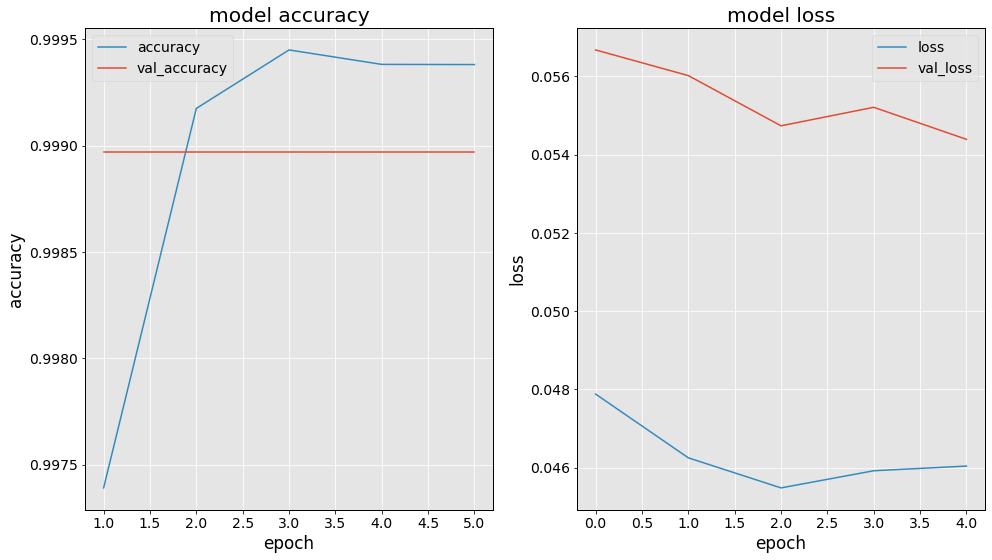

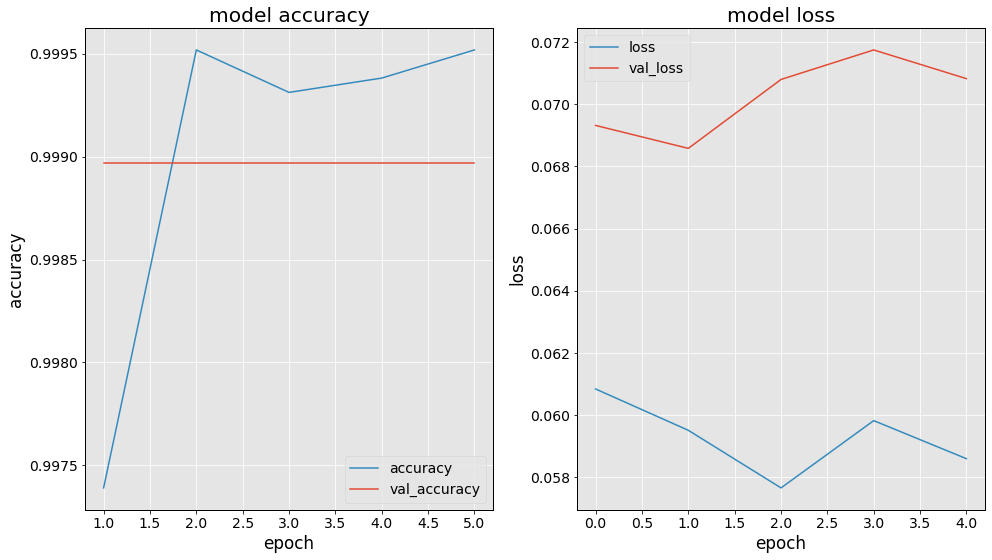

In [10]:
# remove labels 0 and 2
test_labels(df, remove_labels = [2,0])

# Concluding thoughts

I have shown that for this scenario that a simple, clear dataset massively improves performance of a neural network. Performance is significantly improved when the network only has to choose between positive and negative tweets. 

## Lessons learned

- Preprocessing tweets is tough.
    - There are a lot of packages to do so. Some of these are very resource intensive so I would only use them if it was on a really big job where maximising performance is necessary. 
    - There could be a lot of ways to improve this including using pretrained models and tuning hyperparameters in the preprocessing or the model. 
- Senitment analysis is hard. 
    - The network only really performs well in the simplest case. I'm not a NLP expert and its tough to see how to improve it.
- Overfitting is still an issue, In all the networks, the data is being overfitted. Not quite sure what to do to fix this other than make the network much simpler. 
    - It could be from how the training and validation set are being split up. 

## Future

NLP is very different to my usual quantitative work and I feel I have a lot to learn. However, this has been a great experience and I look forward to trying out new projects in NLP. 